In [1]:
import numpy as np
from matplotlib import pyplot as plt
# import pandas as pd
import os
import cv2
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten
import copy
import pickle

# Importing data

In [2]:
def data_import(data_path):
    class_labels = os.listdir(data_path) # reads directory names as class-labels
    data=[]
    labels=[]
    for class_ in class_labels:
        if class_ == '.DS_Store':
            continue
        class_path = data_path+'/'+class_
        imgs = os.listdir(class_path) # reads images names to read
        for img in imgs:
            if img == '.DS_Store':
                continue
            data.append(cv2.imread(class_path+'/'+img, cv2.IMREAD_GRAYSCALE))
            labels.append(int(class_))

    return np.array(data), np.array(labels)

In [3]:
test_path='./Group_10/test'
train_path='./Group_10/train'
val_path='./Group_10/val'
# test_data, test_labels = data_import(test_path)
# train_data, train_labels = data_import(train_path)
# val_data, val_labels = data_import(val_path)

# with open('test_data', mode='wb') as f:
#     pickle.dump(test_data, f)
# with open('train_data', mode='wb') as f:
#     pickle.dump(train_data, f)
# with open('val_data', mode='wb') as f:
#     pickle.dump(val_data, f)

# with open('test_labels', mode='wb') as f:
#     pickle.dump(test_labels, f)
# with open('train_labels', mode='wb') as f:
#     pickle.dump(train_labels, f)
# with open('val_labels', mode='wb') as f:
#     pickle.dump(val_labels, f)

with open('test_data', mode='rb') as f:
    test_data = pickle.load(f)
with open('train_data', mode='rb') as f:
    train_data = pickle.load(f)
with open('val_data', mode='rb') as f:
    val_data = pickle.load(f)

with open('test_labels', mode='rb') as f:
    test_labels = pickle.load(f)
with open('train_labels', mode='rb') as f:
    train_labels = pickle.load(f)
with open('val_labels', mode='rb') as f:
    val_labels = pickle.load(f)

print('Summary of data')
print(f'No. of train images: {len(train_data)}')
print(f'No. of test images: {len(test_data)}')
print(f'No. of val images: {len(val_data)}')

Summary of data
No. of train images: 11385
No. of test images: 3795
No. of val images: 3795


# RMSProp

### Model

In [4]:
initializer = keras.initializers.RandomUniform(minval=-1, maxval=1, seed=6)
# Three layer FCNN
model_3 = keras.Sequential([
    Flatten(input_shape=(28,28), name='Input_layer'), # image data as input
    Dense(250, activation='sigmoid', name='Hidden_layer_1'),
    Dense(400, activation='sigmoid', name='Hidden_layer_2'),
    Dense(100, activation='sigmoid', name='Hidden_layer_3'),
    Dense(10, activation='softmax', name='Output')
], name='FCNN_3layer')
model_3.summary()

Model: "FCNN_3layer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (Flatten)       (None, 784)               0         
                                                                 
 Hidden_layer_1 (Dense)      (None, 250)               196250    
                                                                 
 Hidden_layer_2 (Dense)      (None, 400)               100400    
                                                                 
 Hidden_layer_3 (Dense)      (None, 100)               40100     
                                                                 
 Output (Dense)              (None, 10)                1010      
                                                                 
Total params: 337,760
Trainable params: 337,760
Non-trainable params: 0
_________________________________________________________________


In [5]:
earlystopping = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-4, patience=2, verbose=1)
adam = keras.optimizers.Adam(learning_rate=0.001,
        beta_1=0.9, beta_2=0.999, epsilon=1e-8,
        name="Adam")
model_3.compile(optimizer=adam,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [6]:
history = model_3.fit(x=train_data, y=train_labels, batch_size=1, epochs=100_000,
                    callbacks=[earlystopping],
                    verbose=1, shuffle=True,
                    validation_data=(val_data, val_labels), validation_batch_size=None)

Epoch 1/100000


2023-03-16 19:28:06.193989: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


11385/11385 [==============================] - 16s 1ms/step - loss: 0.2688 - accuracy: 0.9101 - val_loss: 0.1910 - val_accuracy: 0.9370
Epoch 2/100000
11385/11385 [==============================] - 14s 1ms/step - loss: 0.1588 - accuracy: 0.9511 - val_loss: 0.1565 - val_accuracy: 0.9560
Epoch 3/100000
11385/11385 [==============================] - 14s 1ms/step - loss: 0.1292 - accuracy: 0.9605 - val_loss: 0.1737 - val_accuracy: 0.9502
Epoch 4/100000
11385/11385 [==============================] - 14s 1ms/step - loss: 0.1254 - accuracy: 0.9635 - val_loss: 0.1467 - val_accuracy: 0.9557
Epoch 5/100000
11385/11385 [==============================] - 14s 1ms/step - loss: 0.1143 - accuracy: 0.9663 - val_loss: 0.1012 - val_accuracy: 0.9697
Epoch 6/100000
11385/11385 [==============================] - 14s 1ms/step - loss: 0.1037 - accuracy: 0.9695 - val_loss: 0.1114 - val_accuracy: 0.9697
Epoch 7/100000
11385/11385 [==============================] - 14s 1ms/step - loss: 0.1004 - accuracy: 0.9721 

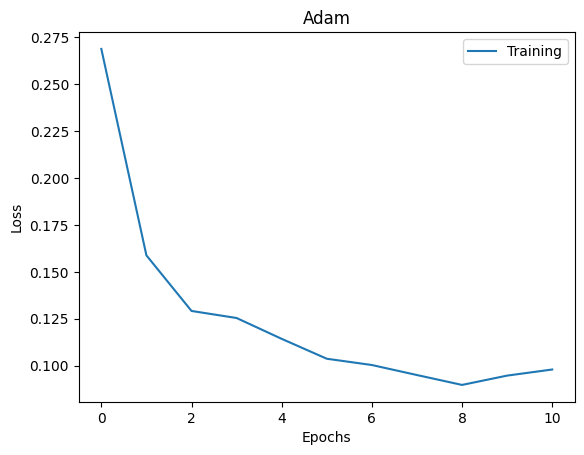

In [7]:
plt.figure()
plt.title("Adam")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.plot(history.history['loss'], label='Training')
# plt.plot(history.history['val_loss'], label='Validation')
plt.legend()

### Test

In [8]:
model_3.evaluate(test_data, test_labels)

119/119 [==============================] - 0s 645us/step - loss: 0.1214 - accuracy: 0.9660


[0.12136799842119217, 0.9660078883171082]

In [10]:
pred_labels = model_3.predict(test_data, verbose=0)
pred_labels = np.argmax(pred_labels, axis=1)

confusion_matrix = tf.math.confusion_matrix(test_labels, pred_labels, num_classes=10)
print('(Adam)Confusion matrix on test data:\n')
print(confusion_matrix.numpy())

(Adam)Confusion matrix on test data:

[[732   0  16   0   0   0   3   8   0   0]
 [  0 745   7   0   0   0   3   4   0   0]
 [ 13   4 704   0   0   0   7  31   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  8   3  11   0   0   0 737   0   0   0]
 [  2   1   8   0   0   0   0 748   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]]
